In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
crew = (
    pl.scan_csv('title.crew.tsv', 
            infer_schema_length=500_000, 
            truncate_ragged_lines=True,
            separator='\t', 
            null_values="\\N",
            quote_char=None
    )
    .with_columns(
        titleKey = pl.col('tconst'),
        writers = pl.col('writers').str.split(',')
    )
    .select(
        'directors',
        'titleKey',
        'writers'
    )
    # .with_columns(
    #     cost = pl.lit(5.0),
    #     new_cost = pl.lit(55).cast(pl.Int32)
    # )
    # .explode('writers')
    .sort('titleKey')
    # .select(
    #     'titleKey',
    #     'writers'
    # )
).collect()
crew

directors,titleKey,writers
str,str,list[str]
"""nm0005690""","""tt0000001""",null
"""nm0721526""","""tt0000002""",null
"""nm0721526""","""tt0000003""","[""nm0721526""]"
"""nm0721526""","""tt0000004""",null
"""nm0005690""","""tt0000005""",null
…,…,…
"""nm1485677""","""tt9916848""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"
"""nm1485677""","""tt9916850""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"
"""nm1485677""","""tt9916852""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"


In [22]:
crew.tail(3)

titleKey,writers,cost,new_cost
str,str,f64,i32
"""tt9916856""","""nm6951431""",5.0,55
"""tt9916880""","""nm1482639""",5.0,55
"""tt9916880""","""nm2586970""",5.0,55


In [31]:
temp = crew.tail(3)

In [32]:
pl.sql(
    ''' 
    SELECT 
        titleKey,
        MIN(writers) AS writers,
        SUM(cost) AS cost,
    FROM 
        temp
    GROUP BY
        titleKey
    '''
).collect()

titleKey,writers,cost
str,str,f64
"""tt9916856""","""nm6951431""",5.0
"""tt9916880""","""nm1482639""",10.0


In [30]:
crew.tail(3).group_by('titleKey').agg(
    pl.col('writers'),
    pl.col('cost').sum(),
)

titleKey,writers,cost
str,list[str],f64
"""tt9916856""","[""nm6951431""]",5.0
"""tt9916880""","[""nm1482639"", ""nm2586970""]",10.0


In [28]:
crew.tail(3).group_by('titleKey').agg(
    pl.col('writers'),
    pl.col('cost'),
    pl.col('new_cost')
).explode('writers')

titleKey,writers,cost,new_cost
str,str,list[f64],list[i32]
"""tt9916856""","""nm6951431""",[5.0],[55]
"""tt9916880""","""nm1482639""","[5.0, 5.0]","[55, 55]"
"""tt9916880""","""nm2586970""","[5.0, 5.0]","[55, 55]"


In [59]:
name = (
    pl.scan_csv('name.basics.tsv', 
            infer_schema_length=500_000, 
            truncate_ragged_lines=True,
            separator='\t', 
            null_values="\\N",
            quote_char=None
    )
    .with_columns(
        nameId = pl.col('nconst')
    )
).collect()
name

nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,nameId
str,str,i64,i64,str,str,str
"""nm0000001""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0027125,…","""nm0000001"""
"""nm0000002""","""Lauren Bacall""",1924,2014,"""actress,soundtrack,archive_foo…","""tt0037382,tt0075213,tt0117057,…","""nm0000002"""
"""nm0000003""","""Brigitte Bardot""",1934,null,"""actress,music_department,produ…","""tt0057345,tt0049189,tt0056404,…","""nm0000003"""
"""nm0000004""","""John Belushi""",1949,1982,"""actor,writer,music_department""","""tt0072562,tt0077975,tt0080455,…","""nm0000004"""
"""nm0000005""","""Ingmar Bergman""",1918,2007,"""writer,director,actor""","""tt0050986,tt0069467,tt0050976,…","""nm0000005"""
…,…,…,…,…,…,…
"""nm9993714""","""Romeo del Rosario""",null,null,"""animation_department,art_depar…","""tt11657662,tt14069590,tt245554…","""nm9993714"""
"""nm9993716""","""Essias Loberg""",null,null,null,null,"""nm9993716"""
"""nm9993717""","""Harikrishnan Rajan""",null,null,"""cinematographer""","""tt8736744""","""nm9993717"""


In [60]:
filtered_name_data = (
    name.select('primaryName', 'nameId')
)
filtered_name_data

primaryName,nameId
str,str
"""Fred Astaire""","""nm0000001"""
"""Lauren Bacall""","""nm0000002"""
"""Brigitte Bardot""","""nm0000003"""
"""John Belushi""","""nm0000004"""
"""Ingmar Bergman""","""nm0000005"""
…,…
"""Romeo del Rosario""","""nm9993714"""
"""Essias Loberg""","""nm9993716"""
"""Harikrishnan Rajan""","""nm9993717"""


In [5]:
lookup_dict = dict(zip(name['nconst'], name['primaryName']))
lookup_dict

{'nm0000001': 'Fred Astaire',
 'nm0000002': 'Lauren Bacall',
 'nm0000003': 'Brigitte Bardot',
 'nm0000004': 'John Belushi',
 'nm0000005': 'Ingmar Bergman',
 'nm0000006': 'Ingrid Bergman',
 'nm0000007': 'Humphrey Bogart',
 'nm0000008': 'Marlon Brando',
 'nm0000009': 'Richard Burton',
 'nm0000010': 'James Cagney',
 'nm0000011': 'Gary Cooper',
 'nm0000012': 'Bette Davis',
 'nm0000013': 'Doris Day',
 'nm0000014': 'Olivia de Havilland',
 'nm0000015': 'James Dean',
 'nm0000016': 'Georges Delerue',
 'nm0000017': 'Marlene Dietrich',
 'nm0000018': 'Kirk Douglas',
 'nm0000019': 'Federico Fellini',
 'nm0000020': 'Henry Fonda',
 'nm0000021': 'Joan Fontaine',
 'nm0000022': 'Clark Gable',
 'nm0000023': 'Judy Garland',
 'nm0000024': 'John Gielgud',
 'nm0000025': 'Jerry Goldsmith',
 'nm0000026': 'Cary Grant',
 'nm0000027': 'Alec Guinness',
 'nm0000028': 'Rita Hayworth',
 'nm0000029': 'Margaux Hemingway',
 'nm0000030': 'Audrey Hepburn',
 'nm0000031': 'Katharine Hepburn',
 'nm0000032': 'Charlton Heston'

In [6]:
crew_df = (
    crew
    .with_columns(
        writersList = pl.col('writers').str.split(',')
    )
)
crew_df

tconst,directors,writers,writersList
str,str,str,list[str]
"""tt0000001""","""nm0005690""",null,null
"""tt0000002""","""nm0721526""",null,null
"""tt0000003""","""nm0721526""","""nm0721526""","[""nm0721526""]"
"""tt0000004""","""nm0721526""",null,null
"""tt0000005""","""nm0005690""",null,null
…,…,…,…
"""tt9916848""","""nm1485677""","""nm9187127,nm1485677,nm9826385,…","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"
"""tt9916850""","""nm1485677""","""nm9187127,nm1485677,nm9826385,…","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"
"""tt9916852""","""nm1485677""","""nm9187127,nm1485677,nm9826385,…","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"


In [7]:
test_crew_df = crew_df.with_columns(
    test =  pl.col('writersList').list.eval(
        pl.element().map_elements(lambda x: lookup_dict.get(x, "\\N"), return_dtype=pl.Utf8)
    )
)
test_crew_df

tconst,directors,writers,writersList,test
str,str,str,list[str],list[str]
"""tt0000001""","""nm0005690""",null,null,null
"""tt0000002""","""nm0721526""",null,null,null
"""tt0000003""","""nm0721526""","""nm0721526""","[""nm0721526""]","[""Émile Reynaud""]"
"""tt0000004""","""nm0721526""",null,null,null
"""tt0000005""","""nm0005690""",null,null,null
…,…,…,…,…
"""tt9916848""","""nm1485677""","""nm9187127,nm1485677,nm9826385,…","[""nm9187127"", ""nm1485677"", … ""nm1628284""]","[""Yelda Acikgoz"", ""Hamdi Alkan"", … ""Birol Güven""]"
"""tt9916850""","""nm1485677""","""nm9187127,nm1485677,nm9826385,…","[""nm9187127"", ""nm1485677"", … ""nm1628284""]","[""Yelda Acikgoz"", ""Hamdi Alkan"", … ""Birol Güven""]"
"""tt9916852""","""nm1485677""","""nm9187127,nm1485677,nm9826385,…","[""nm9187127"", ""nm1485677"", … ""nm1628284""]","[""Yelda Acikgoz"", ""Hamdi Alkan"", … ""Birol Güven""]"


In [61]:
crew

titleKey,writers
str,list[str]
"""tt0000001""",null
"""tt0000002""",null
"""tt0000003""","[""nm0721526""]"
"""tt0000004""",null
"""tt0000005""",null
…,…
"""tt9916848""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"
"""tt9916850""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"
"""tt9916852""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"


In [56]:
crew = (
    crew 
    .lazy()
    .rename({
        'writers':'nameId'
    })
    .collect()
)
crew

titleKey,nameId
str,str
"""tt0000001""",null
"""tt0000002""",null
"""tt0000003""","""nm0721526"""
"""tt0000004""",null
"""tt0000005""",null
…,…
"""tt9916852""","""nm9299459"""
"""tt9916852""","""nm1628284"""
"""tt9916856""","""nm6951431"""


In [43]:
filtered_name_data

primaryName,nameId
str,str
"""Fred Astaire""","""nm0000001"""
"""Lauren Bacall""","""nm0000002"""
"""Brigitte Bardot""","""nm0000003"""
"""John Belushi""","""nm0000004"""
"""Ingmar Bergman""","""nm0000005"""
…,…
"""Romeo del Rosario""","""nm9993714"""
"""Essias Loberg""","""nm9993716"""
"""Harikrishnan Rajan""","""nm9993717"""


In [45]:
raw_joined_data =(
    crew 
    .lazy()
    .join(
        filtered_name_data.lazy(),
        on='nameId',
        how='left'
    )
    .collect()
)
raw_joined_data

titleKey,nameId,primaryName
str,str,str
"""tt0000001""",null,null
"""tt0000002""",null,null
"""tt0000003""","""nm0721526""","""Émile Reynaud"""
"""tt0000004""",null,null
"""tt0000005""",null,null
…,…,…
"""tt9916852""","""nm9299459""","""Nur Özlem Elginöz"""
"""tt9916852""","""nm1628284""","""Birol Güven"""
"""tt9916856""","""nm6951431""","""Johan Planefeldt"""


In [66]:
name

nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,nameId
str,str,i64,i64,str,str,str
"""nm0000001""","""Fred Astaire""",1899,1987,"""actor,miscellaneous,producer""","""tt0072308,tt0050419,tt0027125,…","""nm0000001"""
"""nm0000002""","""Lauren Bacall""",1924,2014,"""actress,soundtrack,archive_foo…","""tt0037382,tt0075213,tt0117057,…","""nm0000002"""
"""nm0000003""","""Brigitte Bardot""",1934,null,"""actress,music_department,produ…","""tt0057345,tt0049189,tt0056404,…","""nm0000003"""
"""nm0000004""","""John Belushi""",1949,1982,"""actor,writer,music_department""","""tt0072562,tt0077975,tt0080455,…","""nm0000004"""
"""nm0000005""","""Ingmar Bergman""",1918,2007,"""writer,director,actor""","""tt0050986,tt0069467,tt0050976,…","""nm0000005"""
…,…,…,…,…,…,…
"""nm9993714""","""Romeo del Rosario""",null,null,"""animation_department,art_depar…","""tt11657662,tt14069590,tt245554…","""nm9993714"""
"""nm9993716""","""Essias Loberg""",null,null,null,null,"""nm9993716"""
"""nm9993717""","""Harikrishnan Rajan""",null,null,"""cinematographer""","""tt8736744""","""nm9993717"""


In [70]:
(
    crew 
    .lazy()
    .explode('writers')
    .join(
        name.select('nameId', 'primaryName').lazy(),
        left_on='writers',
        right_on='nameId',
        how='left'
    )
    .group_by('titleKey', 'directors')
    .agg(
        pl.col('writers')
    )
    .collect()
)

titleKey,directors,writers
str,str,list[str]
"""tt32327661""","""nm16121068""",[null]
"""tt21864494""",null,[null]
"""tt12788842""",null,[null]
"""tt13215068""",null,[null]
"""tt5478178""","""nm2263151""","[""nm2263151""]"
…,…,…
"""tt27669487""",null,[null]
"""tt0439082""","""nm0387695""","[""nm14117893"", ""nm0154665"", … ""nm0941280""]"
"""tt12581624""",null,[null]


In [ ]:
(
    crew_df 
    .explode('writersList')
    .join(
        name.select('nameId', 'primaryName'),
        left_on='writersList',
        right_on='nameId',
        how='left'
    )
    .group_by('tconst', 'directors')
    .agg(
        pl.col('writersList'),
        pl.col('primaryName')
    )
    .sort('tconst')
)

In [57]:
(
    raw_joined_data
    .lazy()
    .group_by('titleKey', 'nameId')
    .agg(
        pl.col('primaryName')
    )
    .collect()
)

titleKey,nameId,primaryName
str,str,list[str]
"""tt15223488""",null,[null]
"""tt14371768""","""nm0462293""","[""Egmont R. Koch""]"
"""tt0943766""","""nm2622545""","[""Rose Impey""]"
"""tt8949966""","""nm0308318""","[""Marissa Garrido""]"
"""tt9128622""","""nm1840982""","[""Suzette Doctolero""]"
…,…,…
"""tt7310004""","""nm0847014""","[""Akemi Takada""]"
"""tt14693792""","""nm7418837""","[""Nada Clontz""]"
"""tt14959400""","""nm2591398""","[""Iván Salas-Moya""]"


In [ ]:
    # .group_by('tconst', 'directors')
    # .agg(
    #     pl.col('writersList'),
    #     pl.col('primaryName')
    # )
    # .sort('tconst')

In [ ]:
crew.join(
    filtered_name_data,
    
)

titleKey,writers
str,str
"""tt0000001""",null
"""tt0000002""",null
"""tt0000003""","""nm0721526"""
"""tt0000004""",null
"""tt0000005""",null
…,…
"""tt9916852""","""nm9299459"""
"""tt9916852""","""nm1628284"""
"""tt9916856""","""nm6951431"""


In [28]:
(
    crew_df 
    .explode('writersList')
    .join(
        name.select('nameId', 'primaryName'),
        left_on='writersList',
        right_on='nameId',
        how='left'
    )
    .group_by('tconst', 'writersList')
    .agg(
        pl.col('writers')
    )
    # .group_by('tconst', 'directors')
    # .agg(
    #     pl.col('writersList'),
    #     pl.col('primaryName')
    # )
    # .sort('tconst')
)

tconst,writersList,writers
str,str,list[str]
"""tt13782440""","""nm12205942""","[""nm12205942,nm6119016""]"
"""tt10855202""","""nm10927214""","[""nm10927214""]"
"""tt15392750""",null,[null]
"""tt1622842""","""nm2338252""","[""nm2338252""]"
"""tt18646586""","""nm5734959""","[""nm5734959""]"
…,…,…
"""tt12046202""","""nm1791933""","[""nm1791933""]"
"""tt13961070""","""nm5042664""","[""nm5042664""]"
"""tt15822554""","""nm3591597""","[""nm3591597""]"


In [26]:
(
    crew_df 
    .explode('writersList')
    .join(
        name.select('nameId', 'primaryName'),
        left_on='writersList',
        right_on='nameId',
        how='left'
    )
    .group_by('tconst', 'directors')
    .agg(
        pl.col('writersList'),
        pl.col('primaryName')
    )
    .sort('tconst')
)

tconst,directors,writersList,primaryName
str,str,list[str],list[str]
"""tt0000001""","""nm0005690""",[null],[null]
"""tt0000002""","""nm0721526""",[null],[null]
"""tt0000003""","""nm0721526""","[""nm0721526""]","[""Émile Reynaud""]"
"""tt0000004""","""nm0721526""",[null],[null]
"""tt0000005""","""nm0005690""",[null],[null]
…,…,…,…
"""tt9916848""","""nm1485677""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]","[""Yelda Acikgoz"", ""Hamdi Alkan"", … ""Birol Güven""]"
"""tt9916850""","""nm1485677""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]","[""Yelda Acikgoz"", ""Hamdi Alkan"", … ""Birol Güven""]"
"""tt9916852""","""nm1485677""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]","[""Yelda Acikgoz"", ""Hamdi Alkan"", … ""Birol Güven""]"


In [24]:
(
    crew_df
    .lazy()
    .explode('writersList')
    .join(
        name
        .lazy()
        .select('nameId', 'primaryName'),
        left_on='writersList',
        right_on='nameId',
        how='left'
    )
    .group_by('tconst', 'directors')
    .agg(
        pl.col('writersList'),
        pl.col('primaryName')
    )
    .collect()
)

tconst,directors,writersList,primaryName
str,str,list[str],list[str]
"""tt34317242""","""nm6295009""","[""nm2727976"", ""nm6173961""]","[""Christian Lex"", ""Angelika Schwarzhuber""]"
"""tt35397334""","""nm11169856""",[null],[null]
"""tt7995744""",null,"[""nm1188869""]","[""Everett Rhodes Castle""]"
"""tt6556078""",null,[null],[null]
"""tt0435922""",null,[null],[null]
…,…,…,…
"""tt4598840""","""nm7246348""",[null],[null]
"""tt12891118""",null,[null],[null]
"""tt14634432""","""nm8332119""","[""nm12469466"", ""nm8332126"", ""nm9719803""]","[""Rajendrakumar Ghag"", ""Pralhad Kudtarkar"", ""Latika Sawant""]"


In [22]:
(
    crew_df 
    .explode('writersList')
    .join(
        name.select('nameId', 'primaryName'),
        left_on='writersList',
        right_on='nameId',
        how='left'
    )
    .group_by('tconst', 'directors')
    .agg(
        pl.col('writersList'),
        pl.col('primaryName')
    ).filter(
        pl.col('tconst') == "tt9916880",
        pl.col('directors') == "nm0996406",
    )
)

tconst,directors,writersList,primaryName
str,str,list[str],list[str]
"""tt9916880""","""nm0996406""","[""nm1482639"", ""nm2586970""]","[""Lucinda Whiteley"", ""Francesca Simon""]"


In [23]:
(
    crew_df
    .lazy()
    .explode('writersList')
    .join(
        name
        .lazy()
        .select('nameId', 'primaryName'),
        left_on='writersList',
        right_on='nameId',
        how='left'
    )
    .group_by('tconst', 'directors')
    .agg(
        pl.col('writersList'),
        pl.col('primaryName')
    )
    .collect()
)

tconst,directors,writersList,primaryName
str,str,list[str],list[str]
"""tt33089540""","""nm0076653""",[null],[null]
"""tt27207388""","""nm1754495""","[""nm2589207""]","[""Fatih Yildiz""]"
"""tt30197796""","""nm12392036""",[null],[null]
"""tt14334836""","""nm10611593""","[""nm7370686""]","[""Snehasish Chakraborty""]"
"""tt0077245""","""nm3645607""","[""nm3645607""]","[""Robert W. Morgan""]"
…,…,…,…
"""tt21385024""","""nm13886996""","[""nm13886996""]","[""GabrielDropOutFTW124""]"
"""tt36551885""","""nm0016176""","[""nm1942103""]","[""Marta-Libertad Castillo""]"
"""tt12262378""","""nm0332348""","[""nm0060783"", ""nm6342115"", ""nm3923381""]","[""Alan Bateman"", ""Andrew Gardner"", ""Jasper Marlow""]"


In [8]:
crew_df.explode('writersList')

tconst,directors,writers,writersList
str,str,str,str
"""tt0000001""","""nm0005690""",null,null
"""tt0000002""","""nm0721526""",null,null
"""tt0000003""","""nm0721526""","""nm0721526""","""nm0721526"""
"""tt0000004""","""nm0721526""",null,null
"""tt0000005""","""nm0005690""",null,null
…,…,…,…
"""tt9916852""","""nm1485677""","""nm9187127,nm1485677,nm9826385,…","""nm9299459"""
"""tt9916852""","""nm1485677""","""nm9187127,nm1485677,nm9826385,…","""nm1628284"""
"""tt9916856""","""nm10538645""","""nm6951431""","""nm6951431"""


In [12]:
title_data = (
    pl.scan_csv('title.basics.tsv', 
            infer_schema_length=500_000, 
            truncate_ragged_lines=True,
            separator='\t', 
            null_values="\\N",
            quote_char=None
)
).collect()
title_data

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
str,str,str,str,i64,i64,i64,i64,str
"""tt0000001""","""short""","""Carmencita""","""Carmencita""",0,1894,null,1,"""Documentary,Short"""
"""tt0000002""","""short""","""Le clown et ses chiens""","""Le clown et ses chiens""",0,1892,null,5,"""Animation,Short"""
"""tt0000003""","""short""","""Poor Pierrot""","""Pauvre Pierrot""",0,1892,null,5,"""Animation,Comedy,Romance"""
"""tt0000004""","""short""","""Un bon bock""","""Un bon bock""",0,1892,null,12,"""Animation,Short"""
"""tt0000005""","""short""","""Blacksmith Scene""","""Blacksmith Scene""",0,1893,null,1,"""Short"""
…,…,…,…,…,…,…,…,…
"""tt9916848""","""tvEpisode""","""Episode #3.17""","""Episode #3.17""",0,2009,null,null,"""Drama"""
"""tt9916850""","""tvEpisode""","""Episode #3.19""","""Episode #3.19""",0,2010,null,null,"""Drama"""
"""tt9916852""","""tvEpisode""","""Episode #3.20""","""Episode #3.20""",0,2010,null,null,"""Drama"""


In [9]:
data.with_columns(
    pl.col('writers').str.split(',')
)

tconst,directors,writers
str,str,list[str]
"""tt0000001""","""nm0005690""",null
"""tt0000002""","""nm0721526""",null
"""tt0000003""","""nm0721526""","[""nm0721526""]"
"""tt0000004""","""nm0721526""",null
"""tt0000005""","""nm0005690""",null
…,…,…
"""tt9916848""","""nm1485677""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"
"""tt9916850""","""nm1485677""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"
"""tt9916852""","""nm1485677""","[""nm9187127"", ""nm1485677"", … ""nm1628284""]"


In [7]:
data['writers']

writers
str
null
null
"""nm0721526"""
null
null
…
"""nm9187127,nm1485677,nm9826385,…"
"""nm9187127,nm1485677,nm9826385,…"
"""nm9187127,nm1485677,nm9826385,…"


In [3]:
raw_df = pl.read_csv('cleaned_knee_data.csv')
raw_df

patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,body_mass_index,admission_cost,follow_up_meeting_count,Prof Fees,ED Visit/s Cost,re_admit_one,re_admit_two,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost
i64,i64,str,str,str,f64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64
67838,45,"""Female""","""Female""","""Black or African American""",7.5,"""Rideshare-Taxi-Bus""","""DJD""","""Chronic Lung Disease Hx""","""No""",43,44531,0,375,0,8462,6752,3447,8,1253,245,7450,0,0,"""Home-Self Care""",72515.0
67839,52,"""Female""","""Female""","""Black or African American""",7.5,"""Rideshare-Taxi-Bus""","""OA""","""Chronic Lung Disease Hx""","""No""",25,44648,0,375,1993,0,0,0,21,3102,428,9318,0,0,"""Home-Self Care""",59864.0
67840,55,"""Female""","""Female""","""Hispanic or Latino""",30.0,"""Private vehicle""","""DJD""","""Chronic Lung Disease Hx""","""No""",43,44949,1,750,0,9482,0,0,16,2457,276,8503,0,0,"""Home-Self Care""",66417.0
67841,55,"""Female""","""Female""","""Asian""",60.0,"""Private vehicle""","""DJD""","""Chronic Lung Disease Hx""","""No""",45,41120,1,750,0,6743,8888,0,26,3934,252,6345,0,0,"""Home-Self Care""",68032.0
67842,63,"""Female""","""Male""","""Black or African American""",15.0,"""Private vehicle""","""DJD""","""Chronic Lung Disease Hx""","""No""",44,44068,2,1125,0,8337,7638,0,10,1564,402,4565,0,0,"""Home-Self Care""",67699.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
67953,68,"""Male""","""Male""","""White or Caucasian""",7.5,"""Private vehicle""","""OA""","""Other""","""No""",21,43043,2,1125,0,8321,8800,0,13,1987,245,5623,0,0,"""Home-Self Care""",69144.0
67954,70,"""Male""","""Male""","""Black or African American""",7.5,"""Rideshare-Taxi-Bus""","""OA""","""Other""","""Yes""",39,41298,0,375,5789,8378,0,0,0,0,170,7600,0,0,"""Home-Self Care""",63610.0
67955,77,"""Male""","""Female""","""Black or African American""",15.0,"""Private vehicle""","""OA""","""Other""","""No""",45,43297,1,750,0,6755,6544,0,16,2366,311,7673,0,0,"""Home-Self Care""",67696.0


In [138]:
test = pd.read_csv('cleaned_knee_data.csv')
test = test[test["health_condition"] == "Heart Disease Hx"]
test.to_csv('heart.csv')

In [155]:
pd.read_csv('heart.csv')

,Unnamed: 0,patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,...,re_admit_two,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost
0,58,67896,42,Female,Non-binary,White or Caucasian,2.5,Private vehicle,Other,Heart Disease Hx,...,0,0,5,679,387,6786,20,5466,SNF,70373.0
1,59,67897,44,Female,Female,Asian,7.5,Rideshare-Taxi-Bus,OA,Heart Disease Hx,...,12682,0,4,567,367,456,19,5355,SNF,72874.0
2,60,67898,50,Female,Female,White or Caucasian,2.5,Private vehicle,OA,Heart Disease Hx,...,0,0,22,3255,352,6724,0,0,Home-Self Care,53348.0
3,61,67899,53,Female,Male,Asian,2.5,Private vehicle,DJD,Heart Disease Hx,...,0,0,16,2367,401,3245,0,0,Home-Self Care,57455.0
4,62,67900,53,Female,Male,Hispanic or Latino,7.5,Rideshare-Taxi-Bus,DJD,Heart Disease Hx,...,0,0,26,3919,366,7696,0,0,Home-Self Care,63185.0
5,63,67901,54,Female,Male,Asian,7.5,Private vehicle,DJD,Heart Disease Hx,...,0,0,16,2431,311,5020,0,0,Home-Self Care,49892.0
6,64,67902,55,Female,Male,Black or African American,7.5,Private vehicle,OA,Heart Disease Hx,...,0,0,16,2367,371,5698,0,0,Home-Self Care,59173.0
7,65,67903,57,Female,Female,White or Caucasian,7.5,Private vehicle,OA,Heart Disease Hx,...,0,0,22,3290,376,5690,0,0,Home-Self Care,51149.0
8,66,67904,57,Female,Female,White or Caucasian,7.5,Private vehicle,OA,Heart Disease Hx,...,0,0,16,2377,209,4630,0,0,Home-Self Care,51187.0
9,67,67905,57,Female,Female,Hispanic or Latino,7.5,Rideshare-Taxi-Bus,OA,Heart Disease Hx,...,0,0,24,3543,283,9386,0,0,Home-Self Care,59012.0


In [154]:
test

,patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,...,re_admit_two,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost
58,67896,42,Female,Non-binary,White or Caucasian,2.5,Private vehicle,Other,Heart Disease Hx,Yes,...,0,0,5,679,387,6786,20,5466,SNF,70373.0
59,67897,44,Female,Female,Asian,7.5,Rideshare-Taxi-Bus,OA,Heart Disease Hx,No,...,12682,0,4,567,367,456,19,5355,SNF,72874.0
60,67898,50,Female,Female,White or Caucasian,2.5,Private vehicle,OA,Heart Disease Hx,Yes,...,0,0,22,3255,352,6724,0,0,Home-Self Care,53348.0
61,67899,53,Female,Male,Asian,2.5,Private vehicle,DJD,Heart Disease Hx,No,...,0,0,16,2367,401,3245,0,0,Home-Self Care,57455.0
62,67900,53,Female,Male,Hispanic or Latino,7.5,Rideshare-Taxi-Bus,DJD,Heart Disease Hx,Yes,...,0,0,26,3919,366,7696,0,0,Home-Self Care,63185.0
63,67901,54,Female,Male,Asian,7.5,Private vehicle,DJD,Heart Disease Hx,No,...,0,0,16,2431,311,5020,0,0,Home-Self Care,49892.0
64,67902,55,Female,Male,Black or African American,7.5,Private vehicle,OA,Heart Disease Hx,Yes,...,0,0,16,2367,371,5698,0,0,Home-Self Care,59173.0
65,67903,57,Female,Female,White or Caucasian,7.5,Private vehicle,OA,Heart Disease Hx,Yes,...,0,0,22,3290,376,5690,0,0,Home-Self Care,51149.0
66,67904,57,Female,Female,White or Caucasian,7.5,Private vehicle,OA,Heart Disease Hx,Yes,...,0,0,16,2377,209,4630,0,0,Home-Self Care,51187.0
67,67905,57,Female,Female,Hispanic or Latino,7.5,Rideshare-Taxi-Bus,OA,Heart Disease Hx,No,...,0,0,24,3543,283,9386,0,0,Home-Self Care,59012.0


In [4]:
raw_df['health_condition'].value_counts()

health_condition,count
str,u32
"""Heart Disease Hx""",30
"""Diabetes""",17
"""Kidney Disease Hx""",11
"""Chronic Lung Disease Hx""",16
"""Liver Disease Hx""",13
"""Other""",8
"""GI Disease/Disorder Hx""",25


In [18]:
df = raw_df.filter(
    pl.col("health_condition") == "Heart Disease Hx"
)

In [19]:
df = df.with_columns(
    age_groups = (
        pl.when(
            (pl.col('age') >= 40) & (pl.col("age") <= 50)
        )
         .then(pl.lit("40-50"))
         .when((pl.col('age') > 50) & (pl.col("age") <= 60))
         .then(pl.lit('51-60'))
         .when((pl.col('age') > 60) & (pl.col("age") <= 70))
         .then(pl.lit("61-70"))
         .otherwise(pl.lit("71-80"))
    )
)
df

patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,body_mass_index,admission_cost,follow_up_meeting_count,Prof Fees,ED Visit/s Cost,re_admit_one,re_admit_two,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost,age_groups
i64,i64,str,str,str,f64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,str
67896,42,"""Female""","""Non-binary""","""White or Caucasian""",2.5,"""Private vehicle""","""Other""","""Heart Disease Hx""","""Yes""",22,43943,1,750,0,12362,0,0,5,679,387,6786,20,5466,"""SNF""",70373.0,"""40-50"""
67897,44,"""Female""","""Female""","""Asian""",7.5,"""Rideshare-Taxi-Bus""","""OA""","""Heart Disease Hx""","""No""",18,45943,1,750,0,6754,12682,0,4,567,367,456,19,5355,"""SNF""",72874.0,"""40-50"""
67898,50,"""Female""","""Female""","""White or Caucasian""",2.5,"""Private vehicle""","""OA""","""Heart Disease Hx""","""Yes""",26,40123,1,750,0,2144,0,0,22,3255,352,6724,0,0,"""Home-Self Care""",53348.0,"""40-50"""
67899,53,"""Female""","""Male""","""Asian""",2.5,"""Private vehicle""","""DJD""","""Heart Disease Hx""","""No""",33,43903,1,750,0,6789,0,0,16,2367,401,3245,0,0,"""Home-Self Care""",57455.0,"""51-60"""
67900,53,"""Female""","""Male""","""Hispanic or Latino""",7.5,"""Rideshare-Taxi-Bus""","""DJD""","""Heart Disease Hx""","""Yes""",45,42843,1,750,0,7611,0,0,26,3919,366,7696,0,0,"""Home-Self Care""",63185.0,"""51-60"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
67921,75,"""Male""","""Female""","""White or Caucasian""",30.0,"""Private vehicle""","""OA""","""Heart Disease Hx""","""Yes""",33,43573,1,750,0,0,0,0,14,2162,402,7408,0,0,"""Home-Self Care""",54295.0,"""71-80"""
67922,75,"""Male""","""Female""","""White or Caucasian""",30.0,"""Private vehicle""","""OA""","""Heart Disease Hx""","""No""",38,42434,1,750,0,0,0,0,17,2619,167,8139,0,0,"""Home-Self Care""",54109.0,"""71-80"""
67923,78,"""Male""","""Prefer not to state""","""White or Caucasian""",2.5,"""Rideshare-Taxi-Bus""","""DJD""","""Heart Disease Hx""","""Yes""",32,43567,1,750,1432,0,0,0,14,2138,433,0,14,3876,"""Home-Self Care""",52196.0,"""71-80"""


In [55]:
new_t = pd.read_csv('cleaned_knee_data.csv')
new_t

,patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,...,re_admit_two,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost
0,67838,45,Female,Female,Black or African American,7.5,Rideshare-Taxi-Bus,DJD,Chronic Lung Disease Hx,No,...,6752,3447,8,1253,245,7450,0,0,Home-Self Care,72515.0
1,67839,52,Female,Female,Black or African American,7.5,Rideshare-Taxi-Bus,OA,Chronic Lung Disease Hx,No,...,0,0,21,3102,428,9318,0,0,Home-Self Care,59864.0
2,67840,55,Female,Female,Hispanic or Latino,30.0,Private vehicle,DJD,Chronic Lung Disease Hx,No,...,0,0,16,2457,276,8503,0,0,Home-Self Care,66417.0
3,67841,55,Female,Female,Asian,60.0,Private vehicle,DJD,Chronic Lung Disease Hx,No,...,8888,0,26,3934,252,6345,0,0,Home-Self Care,68032.0
4,67842,63,Female,Male,Black or African American,15.0,Private vehicle,DJD,Chronic Lung Disease Hx,No,...,7638,0,10,1564,402,4565,0,0,Home-Self Care,67699.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,67953,68,Male,Male,White or Caucasian,7.5,Private vehicle,OA,Other,No,...,8800,0,13,1987,245,5623,0,0,Home-Self Care,69144.0
116,67954,70,Male,Male,Black or African American,7.5,Rideshare-Taxi-Bus,OA,Other,Yes,...,0,0,0,0,170,7600,0,0,Home-Self Care,63610.0
117,67955,77,Male,Female,Black or African American,15.0,Private vehicle,OA,Other,No,...,6544,0,16,2366,311,7673,0,0,Home-Self Care,67696.0
118,67956,79,Male,Male,White or Caucasian,15.0,Private vehicle,OA,Other,No,...,0,0,0,0,340,0,17,4787,SNF,57024.0


In [61]:
pl.Config.set_tbl_cols(30)
pl.read_csv('cleaned_knee_data.csv')

patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,body_mass_index,admission_cost,follow_up_meeting_count,Prof Fees,ED Visit/s Cost,re_admit_one,re_admit_two,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost
i64,i64,str,str,str,f64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64
67838,45,"""Female""","""Female""","""Black or African American""",7.5,"""Rideshare-Taxi-Bus""","""DJD""","""Chronic Lung Disease Hx""","""No""",43,44531,0,375,0,8462,6752,3447,8,1253,245,7450,0,0,"""Home-Self Care""",72515.0
67839,52,"""Female""","""Female""","""Black or African American""",7.5,"""Rideshare-Taxi-Bus""","""OA""","""Chronic Lung Disease Hx""","""No""",25,44648,0,375,1993,0,0,0,21,3102,428,9318,0,0,"""Home-Self Care""",59864.0
67840,55,"""Female""","""Female""","""Hispanic or Latino""",30.0,"""Private vehicle""","""DJD""","""Chronic Lung Disease Hx""","""No""",43,44949,1,750,0,9482,0,0,16,2457,276,8503,0,0,"""Home-Self Care""",66417.0
67841,55,"""Female""","""Female""","""Asian""",60.0,"""Private vehicle""","""DJD""","""Chronic Lung Disease Hx""","""No""",45,41120,1,750,0,6743,8888,0,26,3934,252,6345,0,0,"""Home-Self Care""",68032.0
67842,63,"""Female""","""Male""","""Black or African American""",15.0,"""Private vehicle""","""DJD""","""Chronic Lung Disease Hx""","""No""",44,44068,2,1125,0,8337,7638,0,10,1564,402,4565,0,0,"""Home-Self Care""",67699.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
67953,68,"""Male""","""Male""","""White or Caucasian""",7.5,"""Private vehicle""","""OA""","""Other""","""No""",21,43043,2,1125,0,8321,8800,0,13,1987,245,5623,0,0,"""Home-Self Care""",69144.0
67954,70,"""Male""","""Male""","""Black or African American""",7.5,"""Rideshare-Taxi-Bus""","""OA""","""Other""","""Yes""",39,41298,0,375,5789,8378,0,0,0,0,170,7600,0,0,"""Home-Self Care""",63610.0
67955,77,"""Male""","""Female""","""Black or African American""",15.0,"""Private vehicle""","""OA""","""Other""","""No""",45,43297,1,750,0,6755,6544,0,16,2366,311,7673,0,0,"""Home-Self Care""",67696.0


In [59]:
scatter_data = pd.read_csv('cleaned_knee_data.csv')
scatter_data

,patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,...,re_admit_two,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost
0,67838,45,Female,Female,Black or African American,7.5,Rideshare-Taxi-Bus,DJD,Chronic Lung Disease Hx,No,...,6752,3447,8,1253,245,7450,0,0,Home-Self Care,72515.0
1,67839,52,Female,Female,Black or African American,7.5,Rideshare-Taxi-Bus,OA,Chronic Lung Disease Hx,No,...,0,0,21,3102,428,9318,0,0,Home-Self Care,59864.0
2,67840,55,Female,Female,Hispanic or Latino,30.0,Private vehicle,DJD,Chronic Lung Disease Hx,No,...,0,0,16,2457,276,8503,0,0,Home-Self Care,66417.0
3,67841,55,Female,Female,Asian,60.0,Private vehicle,DJD,Chronic Lung Disease Hx,No,...,8888,0,26,3934,252,6345,0,0,Home-Self Care,68032.0
4,67842,63,Female,Male,Black or African American,15.0,Private vehicle,DJD,Chronic Lung Disease Hx,No,...,7638,0,10,1564,402,4565,0,0,Home-Self Care,67699.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,67953,68,Male,Male,White or Caucasian,7.5,Private vehicle,OA,Other,No,...,8800,0,13,1987,245,5623,0,0,Home-Self Care,69144.0
116,67954,70,Male,Male,Black or African American,7.5,Rideshare-Taxi-Bus,OA,Other,Yes,...,0,0,0,0,170,7600,0,0,Home-Self Care,63610.0
117,67955,77,Male,Female,Black or African American,15.0,Private vehicle,OA,Other,No,...,6544,0,16,2366,311,7673,0,0,Home-Self Care,67696.0
118,67956,79,Male,Male,White or Caucasian,15.0,Private vehicle,OA,Other,No,...,0,0,0,0,340,0,17,4787,SNF,57024.0


In [62]:
scatter_data['body_mass_index'].describe()

count    120.000000
mean      31.016667
std        8.470397
min       16.000000
25%       24.000000
50%       31.500000
75%       39.000000
max       45.000000
Name: body_mass_index, dtype: float64

In [57]:
scatter_data = pd.read_csv('cleaned_knee_data.csv')
scatter_data['total_readmissions'] =  scatter_data['re_admit_one'] + scatter_data['re_admit_two'] + scatter_data['re_admit_three']
scatter_data = scatter_data[['age', 'total_cost','total_readmissions', 'current_gender']]

scatter_data = scatter_data[scatter_data['total_cost'] >= 40000]
scatter_data

,age,total_cost,total_readmissions,current_gender
0,45,72515.0,18661,Female
1,52,59864.0,0,Female
2,55,66417.0,9482,Female
3,55,68032.0,15631,Female
4,63,67699.0,15975,Male
...,...,...,...,...
115,68,69144.0,17121,Male
116,70,63610.0,8378,Male
117,77,67696.0,13299,Female
118,79,57024.0,8787,Male


In [58]:
scatter_data['total_readmissions'].max()

np.int64(28145)

In [56]:
new_t['total_readmissions'] =  new_t['re_admit_one'] + new_t['re_admit_two'] + new_t['re_admit_three']
new_t

,patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,...,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost,total_readmissions
0,67838,45,Female,Female,Black or African American,7.5,Rideshare-Taxi-Bus,DJD,Chronic Lung Disease Hx,No,...,3447,8,1253,245,7450,0,0,Home-Self Care,72515.0,18661
1,67839,52,Female,Female,Black or African American,7.5,Rideshare-Taxi-Bus,OA,Chronic Lung Disease Hx,No,...,0,21,3102,428,9318,0,0,Home-Self Care,59864.0,0
2,67840,55,Female,Female,Hispanic or Latino,30.0,Private vehicle,DJD,Chronic Lung Disease Hx,No,...,0,16,2457,276,8503,0,0,Home-Self Care,66417.0,9482
3,67841,55,Female,Female,Asian,60.0,Private vehicle,DJD,Chronic Lung Disease Hx,No,...,0,26,3934,252,6345,0,0,Home-Self Care,68032.0,15631
4,67842,63,Female,Male,Black or African American,15.0,Private vehicle,DJD,Chronic Lung Disease Hx,No,...,0,10,1564,402,4565,0,0,Home-Self Care,67699.0,15975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,67953,68,Male,Male,White or Caucasian,7.5,Private vehicle,OA,Other,No,...,0,13,1987,245,5623,0,0,Home-Self Care,69144.0,17121
116,67954,70,Male,Male,Black or African American,7.5,Rideshare-Taxi-Bus,OA,Other,Yes,...,0,0,0,170,7600,0,0,Home-Self Care,63610.0,8378
117,67955,77,Male,Female,Black or African American,15.0,Private vehicle,OA,Other,No,...,0,16,2366,311,7673,0,0,Home-Self Care,67696.0,13299
118,67956,79,Male,Male,White or Caucasian,15.0,Private vehicle,OA,Other,No,...,0,0,0,340,0,17,4787,SNF,57024.0,8787


In [240]:
pl.Config.set_tbl_cols(30)
df = pl.read_csv('cleaned_knee_data.csv')

In [245]:
pd.DataFrame(df, columns=[df.columns]).to_clipboard()

In [190]:
df

patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,body_mass_index,admission_cost,follow_up_meeting_count,Prof Fees,ED Visit/s Cost,re_admit_one,re_admit_two,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost
i64,i64,str,str,str,f64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64
67838,45,"""Female""","""Female""","""Black or African American""",7.5,"""Rideshare-Taxi-Bus""","""DJD""","""Chronic Lung Disease Hx""","""No""",43,44531,0,375,0,8462,6752,3447,8,1253,245,7450,0,0,"""Home-Self Care""",72515.0
67839,52,"""Female""","""Female""","""Black or African American""",7.5,"""Rideshare-Taxi-Bus""","""OA""","""Chronic Lung Disease Hx""","""No""",25,44648,0,375,1993,0,0,0,21,3102,428,9318,0,0,"""Home-Self Care""",59864.0
67840,55,"""Female""","""Female""","""Hispanic or Latino""",30.0,"""Private vehicle""","""DJD""","""Chronic Lung Disease Hx""","""No""",43,44949,1,750,0,9482,0,0,16,2457,276,8503,0,0,"""Home-Self Care""",66417.0
67841,55,"""Female""","""Female""","""Asian""",60.0,"""Private vehicle""","""DJD""","""Chronic Lung Disease Hx""","""No""",45,41120,1,750,0,6743,8888,0,26,3934,252,6345,0,0,"""Home-Self Care""",68032.0
67842,63,"""Female""","""Male""","""Black or African American""",15.0,"""Private vehicle""","""DJD""","""Chronic Lung Disease Hx""","""No""",44,44068,2,1125,0,8337,7638,0,10,1564,402,4565,0,0,"""Home-Self Care""",67699.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
67953,68,"""Male""","""Male""","""White or Caucasian""",7.5,"""Private vehicle""","""OA""","""Other""","""No""",21,43043,2,1125,0,8321,8800,0,13,1987,245,5623,0,0,"""Home-Self Care""",69144.0
67954,70,"""Male""","""Male""","""Black or African American""",7.5,"""Rideshare-Taxi-Bus""","""OA""","""Other""","""Yes""",39,41298,0,375,5789,8378,0,0,0,0,170,7600,0,0,"""Home-Self Care""",63610.0
67955,77,"""Male""","""Female""","""Black or African American""",15.0,"""Private vehicle""","""OA""","""Other""","""No""",45,43297,1,750,0,6755,6544,0,16,2366,311,7673,0,0,"""Home-Self Care""",67696.0


In [208]:
df['transportation'].value_counts()

transportation,count
str,u32
"""Private vehicle""",22
"""Rideshare-Taxi-Bus""",8


In [242]:
t = df.filter(
    pl.col("health_condition") == "Heart Disease Hx"
)
t

patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,body_mass_index,admission_cost,follow_up_meeting_count,Prof Fees,ED Visit/s Cost,re_admit_one,re_admit_two,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost
i64,i64,str,str,str,f64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64
67896,42,"""Female""","""Non-binary""","""White or Caucasian""",2.5,"""Private vehicle""","""Other""","""Heart Disease Hx""","""Yes""",22,43943,1,750,0,12362,0,0,5,679,387,6786,20,5466,"""SNF""",70373.0
67897,44,"""Female""","""Female""","""Asian""",7.5,"""Rideshare-Taxi-Bus""","""OA""","""Heart Disease Hx""","""No""",18,45943,1,750,0,6754,12682,0,4,567,367,456,19,5355,"""SNF""",72874.0
67898,50,"""Female""","""Female""","""White or Caucasian""",2.5,"""Private vehicle""","""OA""","""Heart Disease Hx""","""Yes""",26,40123,1,750,0,2144,0,0,22,3255,352,6724,0,0,"""Home-Self Care""",53348.0
67899,53,"""Female""","""Male""","""Asian""",2.5,"""Private vehicle""","""DJD""","""Heart Disease Hx""","""No""",33,43903,1,750,0,6789,0,0,16,2367,401,3245,0,0,"""Home-Self Care""",57455.0
67900,53,"""Female""","""Male""","""Hispanic or Latino""",7.5,"""Rideshare-Taxi-Bus""","""DJD""","""Heart Disease Hx""","""Yes""",45,42843,1,750,0,7611,0,0,26,3919,366,7696,0,0,"""Home-Self Care""",63185.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
67921,75,"""Male""","""Female""","""White or Caucasian""",30.0,"""Private vehicle""","""OA""","""Heart Disease Hx""","""Yes""",33,43573,1,750,0,0,0,0,14,2162,402,7408,0,0,"""Home-Self Care""",54295.0
67922,75,"""Male""","""Female""","""White or Caucasian""",30.0,"""Private vehicle""","""OA""","""Heart Disease Hx""","""No""",38,42434,1,750,0,0,0,0,17,2619,167,8139,0,0,"""Home-Self Care""",54109.0
67923,78,"""Male""","""Prefer not to state""","""White or Caucasian""",2.5,"""Rideshare-Taxi-Bus""","""DJD""","""Heart Disease Hx""","""Yes""",32,43567,1,750,1432,0,0,0,14,2138,433,0,14,3876,"""Home-Self Care""",52196.0


In [228]:
df = df.with_columns(
    total_readmissions_cost = (
        pl.col('re_admit_one') + pl.col('re_admit_two') + pl.col('re_admit_three')
    ),
    mental_health = (
        pl.when(pl.col('mental_health_disorder_history') == 'Yes')
          .then(pl.lit(1))
          .otherwise(pl.lit(0))
    ),
    d_int = (
        pl.when(pl.col('diagnosis')=="OA")
          .then(pl.lit(0))
          .when(pl.col('diagnosis')=="DJD")
          .then(pl.lit(1))
          .otherwise(pl.lit(2))
    ),
    trans = (
        pl.when(pl.col('birth_gender') != pl.col('current_gender'))
          .then(pl.lit(1))
          .otherwise(pl.lit(0))
    ),
    dis_loc = (
        pl.when(pl.col('discharge_location')=="SNF")
          .then(pl.lit(0))
          .otherwise(pl.lit(1))
    ),
    transport_int = (
        pl.when(pl.col('transportation') == "Private vehicle")
          .then(pl.lit(0))
          .otherwise(pl.lit(1))

    )
).filter(
    pl.col("health_condition") == "Heart Disease Hx"
)
df

patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,body_mass_index,admission_cost,follow_up_meeting_count,Prof Fees,ED Visit/s Cost,…,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost,total_readmissions_cost,mental_health,d_int,trans,dis_loc,transport_int
i64,i64,str,str,str,f64,str,str,str,str,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,str,f64,i64,i32,i32,i32,i32,i32
67896,42,"""Female""","""Non-binary""","""White or Caucasian""",2.5,"""Private vehicle""","""Other""","""Heart Disease Hx""","""Yes""",22,43943,1,750,0,…,0,5,679,387,6786,20,5466,"""SNF""",70373.0,12362,1,2,1,0,0
67897,44,"""Female""","""Female""","""Asian""",7.5,"""Rideshare-Taxi-Bus""","""OA""","""Heart Disease Hx""","""No""",18,45943,1,750,0,…,0,4,567,367,456,19,5355,"""SNF""",72874.0,19436,0,0,0,0,1
67898,50,"""Female""","""Female""","""White or Caucasian""",2.5,"""Private vehicle""","""OA""","""Heart Disease Hx""","""Yes""",26,40123,1,750,0,…,0,22,3255,352,6724,0,0,"""Home-Self Care""",53348.0,2144,1,0,0,1,0
67899,53,"""Female""","""Male""","""Asian""",2.5,"""Private vehicle""","""DJD""","""Heart Disease Hx""","""No""",33,43903,1,750,0,…,0,16,2367,401,3245,0,0,"""Home-Self Care""",57455.0,6789,0,1,1,1,0
67900,53,"""Female""","""Male""","""Hispanic or Latino""",7.5,"""Rideshare-Taxi-Bus""","""DJD""","""Heart Disease Hx""","""Yes""",45,42843,1,750,0,…,0,26,3919,366,7696,0,0,"""Home-Self Care""",63185.0,7611,1,1,1,1,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
67921,75,"""Male""","""Female""","""White or Caucasian""",30.0,"""Private vehicle""","""OA""","""Heart Disease Hx""","""Yes""",33,43573,1,750,0,…,0,14,2162,402,7408,0,0,"""Home-Self Care""",54295.0,0,1,0,1,1,0
67922,75,"""Male""","""Female""","""White or Caucasian""",30.0,"""Private vehicle""","""OA""","""Heart Disease Hx""","""No""",38,42434,1,750,0,…,0,17,2619,167,8139,0,0,"""Home-Self Care""",54109.0,0,0,0,1,1,0
67923,78,"""Male""","""Prefer not to state""","""White or Caucasian""",2.5,"""Rideshare-Taxi-Bus""","""DJD""","""Heart Disease Hx""","""Yes""",32,43567,1,750,1432,…,0,14,2138,433,0,14,3876,"""Home-Self Care""",52196.0,0,1,1,1,1,1


In [229]:
df.filter(
    pl.col('body_mass_index') >= 30
).mean()

patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,body_mass_index,admission_cost,follow_up_meeting_count,Prof Fees,ED Visit/s Cost,…,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost,total_readmissions_cost,mental_health,d_int,trans,dis_loc,transport_int
f64,f64,str,str,str,f64,str,str,str,str,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
67913.133333,67.4,null,null,null,14.333333,null,null,null,null,37.133333,42409.2,1.0,750.0,355.266667,…,0.0,17.266667,2607.6,329.2,6079.466667,0.933333,258.4,null,55679.933333,2890.8,0.4,0.466667,0.466667,1.0,0.266667


In [235]:
df.filter(
    pl.col('body_mass_index') < 30
).group_by(
    'race'
).agg(
    pl.col('admission_cost').mean(),
    pl.col('total_cost').mean(),
)

race,admission_cost,total_cost
str,f64,f64
"""Asian""",43781.666667,57440.666667
"""Black or African American""",44008.0,62175.5
"""White or Caucasian""",42589.333333,54940.666667
"""Hispanic or Latino""",43554.0,59012.0


In [239]:
df.filter(
    pl.col('body_mass_index') < 30
).group_by(
    'race',
    'current_gender'
).agg(
    pl.col('admission_cost').mean(),
    pl.col('total_cost').mean(),
)

race,current_gender,admission_cost,total_cost
str,str,f64,f64
"""White or Caucasian""","""Non-binary""",43943.0,70373.0
"""Asian""","""Male""",41380.0,49892.0
"""Asian""","""Female""",44982.5,61215.0
"""Hispanic or Latino""","""Female""",43554.0,59012.0
"""Black or African American""","""Male""",44008.0,62175.5
"""White or Caucasian""","""Female""",42057.166667,52481.5
"""White or Caucasian""","""Male""",43509.0,54602.0


In [246]:
df.filter(
    pl.col('body_mass_index') >= 30
).group_by(
    'race'
).agg(
    pl.col('admission_cost').mean(),
    pl.col('total_cost').mean(),
)

race,admission_cost,total_cost
str,f64,f64
"""Black or African American""",42629.055556,60768.666667
"""White or Caucasian""",42943.903226,57589.387097
"""Asian""",42231.692308,58954.076923
"""Hispanic or Latino""",43896.0,64801.0


In [234]:
df.filter(
    pl.col('body_mass_index') >= 30
).group_by(
    'race'
).agg(
    pl.col('admission_cost').mean(),
    pl.col('total_cost').mean(),
).filter(
    pl.col('race') == "Hispanic or Latino"
).mean()

race,admission_cost,total_cost
str,f64,f64
null,42843.0,63185.0


In [ ]:
np.array([])

In [ ]:
df.filter(
    pl.col('body_mass_index') >= 30
).group_by(
    'race'
).agg(
    pl.col('admission_cost').mean(),
    pl.col('total_cost').mean(),
)

In [230]:
df.filter(
    pl.col('body_mass_index') < 30
).mean()

patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,body_mass_index,admission_cost,follow_up_meeting_count,Prof Fees,ED Visit/s Cost,…,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost,total_readmissions_cost,mental_health,d_int,trans,dis_loc,transport_int
f64,f64,str,str,str,f64,str,str,str,str,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
67907.866667,60.466667,null,null,null,10.333333,null,null,null,null,23.0,43081.266667,0.866667,700.0,384.666667,…,0.0,15.4,2300.133333,295.4,5278.2,4.666667,1301.8,null,56676.733333,3335.266667,0.4,0.466667,0.4,0.733333,0.266667


In [217]:
df = df.filter(
    pl.col("health_condition") == "Heart Disease Hx"
)

In [218]:
vals = (
    df
    .select(
        'age',
        'distance',
        'body_mass_index',
        'd_int',
        'trans',
        'dis_loc',
        'transport_int',
        'mental_health',
        'admission_cost',
        'follow_up_meeting_count',
        'Prof Fees',
        'pt_session_count',
        'oop_pt_cost',
        'home_equipment_cost',
        'home_health_visit_cost',
        'days_at_skilled_rehab',
        'total_readmissions_cost',
        'total_cost'
    )
)

In [219]:
test = pd.DataFrame(vals, columns=vals.columns).corr(method='pearson').round(3)
test

,age,distance,body_mass_index,d_int,trans,dis_loc,transport_int,mental_health,admission_cost,follow_up_meeting_count,Prof Fees,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,total_readmissions_cost,total_cost
age,1.000,0.340,0.318,-0.099,0.006,0.475,0.121,-0.286,-0.378,-0.060,-0.060,0.187,0.216,-0.269,0.173,-0.380,-0.485,-0.480
distance,0.340,1.000,0.149,0.015,-0.074,-0.215,-0.229,-0.311,0.069,-0.163,-0.163,-0.184,-0.166,-0.157,-0.068,0.068,-0.089,-0.108
body_mass_index,0.318,0.149,1.000,-0.044,-0.024,0.500,-0.098,0.027,-0.335,0.290,0.290,0.293,0.311,0.133,0.392,-0.449,-0.082,-0.100
d_int,-0.099,0.015,-0.044,1.000,0.232,-0.198,0.170,-0.073,-0.023,-0.143,-0.143,-0.071,-0.073,0.150,-0.167,0.279,0.123,0.098
trans,0.006,-0.074,-0.024,0.232,1.000,-0.053,-0.071,0.110,0.252,0.132,0.132,0.044,0.046,0.123,-0.091,0.134,0.287,0.287
dis_loc,0.475,-0.215,0.500,-0.198,-0.053,1.000,0.015,0.120,-0.600,0.163,0.163,0.741,0.752,-0.227,0.555,-0.911,-0.619,-0.597
transport_int,0.121,-0.229,-0.098,0.170,-0.071,0.015,1.000,-0.031,0.105,-0.420,-0.420,0.153,0.154,-0.065,-0.120,0.126,0.029,0.142
mental_health,-0.286,-0.311,0.027,-0.073,0.110,0.120,-0.031,1.000,0.145,0.123,0.123,0.219,0.210,0.133,0.004,0.004,-0.026,0.058
admission_cost,-0.378,0.069,-0.335,-0.023,0.252,-0.600,0.105,0.145,1.000,-0.356,-0.356,-0.403,-0.410,0.139,-0.549,0.579,0.622,0.701
follow_up_meeting_count,-0.060,-0.163,0.290,-0.143,0.132,0.163,-0.420,0.123,-0.356,1.000,1.000,-0.112,-0.116,0.340,0.113,-0.112,-0.056,-0.217


<Axes: xlabel='total_cost', ylabel='total_readmissions_cost'>

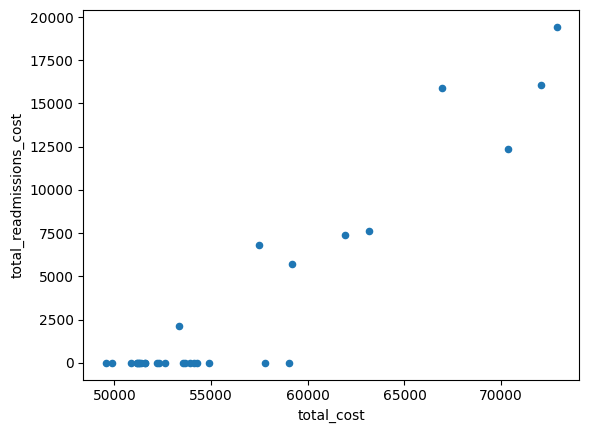

In [227]:
n = pd.DataFrame(vals, columns=vals.columns)
n[['total_readmissions_cost', 'total_cost']].plot(x='total_cost', y='total_readmissions_cost', kind='scatter')

In [221]:
test[['total_readmissions_cost', 'total_cost']]

,total_readmissions_cost,total_cost
age,-0.485,-0.480
distance,-0.089,-0.108
body_mass_index,-0.082,-0.100
d_int,0.123,0.098
trans,0.287,0.287
dis_loc,-0.619,-0.597
transport_int,0.029,0.142
mental_health,-0.026,0.058
admission_cost,0.622,0.701
follow_up_meeting_count,-0.056,-0.217


In [160]:
df

patient_id,age,birth_gender,current_gender,race,distance,transportation,diagnosis,health_condition,mental_health_disorder_history,body_mass_index,admission_cost,follow_up_meeting_count,Prof Fees,ED Visit/s Cost,re_admit_one,re_admit_two,re_admit_three,pt_session_count,oop_pt_cost,home_equipment_cost,home_health_visit_cost,days_at_skilled_rehab,rehab_visit_cost,discharge_location,total_cost
i64,i64,str,str,str,f64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64
67896,42,"""Female""","""Non-binary""","""White or Caucasian""",2.5,"""Private vehicle""","""Other""","""Heart Disease Hx""","""Yes""",22,43943,1,750,0,12362,0,0,5,679,387,6786,20,5466,"""SNF""",70373.0
67897,44,"""Female""","""Female""","""Asian""",7.5,"""Rideshare-Taxi-Bus""","""OA""","""Heart Disease Hx""","""No""",18,45943,1,750,0,6754,12682,0,4,567,367,456,19,5355,"""SNF""",72874.0
67898,50,"""Female""","""Female""","""White or Caucasian""",2.5,"""Private vehicle""","""OA""","""Heart Disease Hx""","""Yes""",26,40123,1,750,0,2144,0,0,22,3255,352,6724,0,0,"""Home-Self Care""",53348.0
67899,53,"""Female""","""Male""","""Asian""",2.5,"""Private vehicle""","""DJD""","""Heart Disease Hx""","""No""",33,43903,1,750,0,6789,0,0,16,2367,401,3245,0,0,"""Home-Self Care""",57455.0
67900,53,"""Female""","""Male""","""Hispanic or Latino""",7.5,"""Rideshare-Taxi-Bus""","""DJD""","""Heart Disease Hx""","""Yes""",45,42843,1,750,0,7611,0,0,26,3919,366,7696,0,0,"""Home-Self Care""",63185.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
67921,75,"""Male""","""Female""","""White or Caucasian""",30.0,"""Private vehicle""","""OA""","""Heart Disease Hx""","""Yes""",33,43573,1,750,0,0,0,0,14,2162,402,7408,0,0,"""Home-Self Care""",54295.0
67922,75,"""Male""","""Female""","""White or Caucasian""",30.0,"""Private vehicle""","""OA""","""Heart Disease Hx""","""No""",38,42434,1,750,0,0,0,0,17,2619,167,8139,0,0,"""Home-Self Care""",54109.0
67923,78,"""Male""","""Prefer not to state""","""White or Caucasian""",2.5,"""Rideshare-Taxi-Bus""","""DJD""","""Heart Disease Hx""","""Yes""",32,43567,1,750,1432,0,0,0,14,2138,433,0,14,3876,"""Home-Self Care""",52196.0


In [163]:
four_chart = df.group_by(
    'distance'
).agg(
    pl.col('total_cost').mean().round(2),
    pl.col('total_cost').max().round(2).alias('max'),
    pl.col('total_cost').median().round(2).alias('median'),
    pl.col('total_cost').min().round(2).alias('min'),
).sort('distance')
four_chart


distance,total_cost,max,median,min
f64,f64,f64,f64,f64
2.5,58343.0,70373.0,55401.5,52196.0
7.5,56335.13,72874.0,53590.0,49892.0
15.0,54613.5,61899.0,52643.5,51268.0
30.0,55360.33,72064.0,52683.0,49556.0


In [142]:
import plotly.express as px

In [148]:
pd.DataFrame(four_chart, columns=four_chart.columns).to_csv('line_one.csv')

In [149]:
pd.read_csv('line_one.csv')

,Unnamed: 0,distance,total_cost,max,median
0,0,30.0,55360.33,72064.0,52683.0
1,1,15.0,54613.50,61899.0,52643.5
2,2,7.5,56335.13,72874.0,53590.0
3,3,2.5,58343.00,70373.0,55401.5


In [27]:
bar_chart_dataframe = df.group_by(
    'age_groups',
    'birth_gender'
).agg(
    pl.col('total_cost').mean().round(2)
).sort('age_groups')

In [122]:
import altair as alt
from vega_datasets import data

source = data.stocks()

alt.Chart(source).mark_line(interpolate="monotone").encode(
    x="date:T",
    y="price:Q",
    color="symbol:N"
)

alt.Chart(...)

In [123]:
source

,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45
...,...,...,...
555,AAPL,2009-11-01,199.91
556,AAPL,2009-12-01,210.73
557,AAPL,2010-01-01,192.06
558,AAPL,2010-02-01,204.62


In [125]:
    # line_one = line_one.sort_values(by='distance')
line_one = pd.read_csv('line_one.csv')
line_one = line_one.drop('Unnamed: 0',axis=1)
line_one =  line_one.sort_values(by='distance')
line_one

,distance,total_cost,max,median
3,2.5,55843.22,72237.0,54067.0
2,7.5,58153.17,73579.0,56717.0
0,15.0,59730.38,73006.0,59312.5
4,30.0,56090.22,72064.0,54295.0
1,60.0,60306.83,76163.0,58983.0


In [120]:
chart_one = px.line(
    line_one,
    y=['total_cost', 'max', 'median'],
    markers=True,
    labels={
        "total_cost":"total_cost",
        "max":"max",
        "median":"median"
    }
)

ValueError: All arguments should have the same length. The length of argument `y` is 3, whereas the length of previously-processed arguments ['index'] is 15

In [ ]:
line_one = line_one.melt(
    id_vars='distance',
    var_name='measure',
    value_name='cost'
)


In [126]:
line_one = line_one.melt(
    id_vars=['distance'],
    value_vars=['max', 'median', 'total_cost'],
    var_name='measure'
)

In [127]:
line_one

,distance,measure,value
0,2.5,max,72237.00
1,7.5,max,73579.00
2,15.0,max,73006.00
3,30.0,max,72064.00
4,60.0,max,76163.00
5,2.5,median,54067.00
6,7.5,median,56717.00
7,15.0,median,59312.50
8,30.0,median,54295.00
9,60.0,median,58983.00


In [134]:
alt.Chart(line_one).mark_line(interpolate="monotone").encode(
    x=alt.X("distance:N", axis=alt.Axis(title="Distance")),
    y = alt.Y("value:Q", scale=alt.Scale(domain=[40000, 80000])),
    color="measure:N"
)

alt.Chart(...)

In [117]:
chart_one = px.line(
    line_one,
    x='distance',
    y='cost',
    markers=True,
    labels={
        "total_cost":"total_cost",
        "max":"max",
        "median":"median"
    }
)

In [118]:
chart_one

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'distance=%{x}<br>cost=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#000001', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('AAAAAAAABEAAAAAAAAAeQAAAAAAAAC' ... 'AAAAAALkAAAAAAAAA+QAAAAAAAAE5A'),
                    'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': ('AAAAANCi8UAAAAAAsPbxQAAAAADg0v' ... 'L1KEwq7UCkcD0KR2PrQPYoXI9acu1A'),
                    'dtype': 'f8'},
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'distance'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'cost'}}}
})

In [31]:
bar_chart_pd = pd.DataFrame(bar_chart_dataframe, columns=[bar_chart_dataframe.columns])
bar_chart_pd

,age_groups,birth_gender,total_cost
0,40-50,Female,65531.67
1,51-60,Female,57889.63
2,61-70,Male,53530.4
3,61-70,Female,54478.25
4,71-80,Male,54007.3


In [34]:
bar_chart_pd = pd.DataFrame(
    bar_chart_dataframe, 
    columns=[bar_chart_dataframe.columns], 
    index=bar_chart_dataframe.select('age_groups').to_series().to_list())
bar_chart_pd

,age_groups,birth_gender,total_cost
40-50,40-50,Female,65531.67
51-60,51-60,Female,57889.63
61-70,61-70,Male,53530.4
61-70,61-70,Female,54478.25
71-80,71-80,Male,54007.3


In [35]:
bar_chart_pd.to_csv('bar.csv')

In [156]:
t = pd.read_csv('bar.csv')
t

,Unnamed: 0,age_groups,birth_gender,total_cost
0,40-50,40-50,Female,65531.67
1,51-60,51-60,Female,57889.63
2,61-70,61-70,Male,53530.40
3,61-70,61-70,Female,54478.25
4,71-80,71-80,Male,54007.30


In [49]:
import streamlit as st
from vega_datasets import data

source = data.barley()

In [50]:
source

,yield,variety,year,site
0,27.00000,Manchuria,1931,University Farm
1,48.86667,Manchuria,1931,Waseca
2,27.43334,Manchuria,1931,Morris
3,39.93333,Manchuria,1931,Crookston
4,32.96667,Manchuria,1931,Grand Rapids
...,...,...,...,...
115,58.16667,Wisconsin No. 38,1932,Waseca
116,47.16667,Wisconsin No. 38,1932,Morris
117,35.90000,Wisconsin No. 38,1932,Crookston
118,20.66667,Wisconsin No. 38,1932,Grand Rapids


In [53]:
t = t.drop('Unnamed: 0',axis=1)
t

,age_groups,birth_gender,total_cost
0,40-50,Female,65531.67
1,51-60,Female,57889.63
2,61-70,Male,53530.40
3,61-70,Female,54478.25
4,71-80,Male,54007.30


In [46]:
grouped =  t.groupby(['birth_gender', "age_groups"])["total_cost"].mean().reset_index()
grouped['Group'] = grouped['birth_gender'] + ' ' + grouped['age_groups']
grouped.set_index('Group', inplace=True)
grouped

,birth_gender,age_groups,total_cost
Group,,,
Female 40-50,Female,40-50,65531.67
Female 51-60,Female,51-60,57889.63
Female 61-70,Female,61-70,54478.25
Male 61-70,Male,61-70,53530.40
Male 71-80,Male,71-80,54007.30


In [ ]:
t = t.set_index('age_groups').drop('Unnamed: 0',axis=1)

,birth_gender,total_cost
age_groups,,
40-50,Female,65531.67
51-60,Female,57889.63
61-70,Male,53530.40
61-70,Female,54478.25
71-80,Male,54007.30


In [ ]:
bar_chart_dataframe

In [28]:
bar_chart_dataframe

age_groups,birth_gender,total_cost
str,str,f64
"""40-50""","""Female""",65531.67
"""51-60""","""Female""",57889.63
"""61-70""","""Male""",53530.4
"""61-70""","""Female""",54478.25
"""71-80""","""Male""",54007.3
